In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
tds = pd.read_pickle("preprocessed/preprocessed_tds_phase_1.pkl")

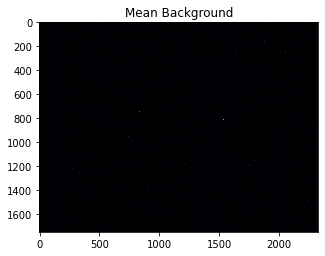

In [3]:
background = tds.loc[1:6,"tds_image"].mean()

plt.figure(figsize=(5,5))
plt.title("Mean Background")
plt.imshow(background, cmap="magma", interpolation="None", vmin=0, vmax=4095)
plt.show()

In [4]:
records = tds.loc[6:,["l1_chrip_phase","charge","tds_image"]]
records

,l1_chrip_phase,charge,tds_image
6,-12.0,0.24380,"[[0, 0, 0, 0, 10, 19, 0, 15, 13, 0, 0, 0, 0, 0..."
7,-12.0,0.25300,"[[0, 0, 0, 0, 4, 0, 2, 1, 11, 0, 0, 0, 8, 12, ..."
8,-12.0,0.25850,"[[0, 0, 0, 1, 15, 0, 14, 0, 19, 0, 3, 0, 0, 9,..."
9,-12.0,0.25395,"[[0, 9, 0, 0, 8, 0, 7, 6, 0, 0, 0, 16, 0, 0, 0..."
10,-12.0,0.24375,"[[4, 0, 0, 0, 22, 11, 0, 0, 18, 6, 23, 0, 0, 0..."
...,...,...,...
191,5.0,0.24900,"[[0, 6, 1, 0, 17, 1, 0, 13, 0, 0, 13, 0, 0, 0,..."
192,5.0,0.25455,"[[0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 25, 0, 0, 0, 1..."
193,5.0,0.25890,"[[0, 0, 0, 0, 22, 11, 0, 0, 0, 1, 26, 0, 0, 7,..."
194,5.0,0.24915,"[[0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [5]:
means = records.groupby("l1_chrip_phase").apply(np.mean).drop("l1_chrip_phase", axis=1)
means["tds_image"] = means["tds_image"].apply(lambda image: image.clip(0, 4095))
means

,charge,tds_image
l1_chrip_phase,,
-12.0,0.249555,"[[1.1, 6.1, 0.0, 0.1, 14.6, 4.2, 2.3, 2.8, 7.0..."
-11.5,0.251580,"[[2.0, 2.6, 3.9, 5.1, 9.3, 0.4, 1.5, 4.7, 10.0..."
-11.0,0.250980,"[[2.8, 3.7, 2.8, 4.2, 6.4, 3.0, 3.4, 9.1, 8.6,..."
-10.5,0.251230,"[[1.9, 3.6, 0.0, 2.8, 10.1, 5.1, 1.7, 1.9, 9.5..."
-10.0,0.252430,"[[8.3, 4.2, 7.5, 5.2, 7.4, 2.1, 2.1, 5.4, 6.1,..."
-9.5,0.250505,"[[1.0, 2.0, 5.7, 3.3, 6.1, 6.0, 0.0, 4.9, 3.4,..."
-9.0,0.250800,"[[4.75, 5.95, 2.8, 1.0, 7.8, 2.85, 3.75, 4.35,..."
-8.5,0.253225,"[[2.95, 6.15, 3.15, 3.65, 7.7, 1.55, 2.6, 2.85..."
-8.0,0.250635,"[[0.3, 2.3, 1.4, 1.0, 9.6, 3.1, 7.0, 5.5, 11.1..."


In [6]:
remove_background = lambda image: (image - background).clip(0, 4095)
clean = means
clean["tds_image"] = means["tds_image"].apply(remove_background)
clean

,charge,tds_image
l1_chrip_phase,,
-12.0,0.249555,"[[0.0, 1.4333333333333327, 0.0, 0.0, 0.0, 0.0,..."
-11.5,0.251580,"[[0.0, 0.0, 2.7333333333333334, 2.933333333333..."
-11.0,0.250980,"[[0.46666666666666634, 0.0, 1.633333333333333,..."
-10.5,0.251230,"[[0.0, 0.0, 0.0, 0.6333333333333333, 0.0, 0.0,..."
-10.0,0.252430,"[[5.966666666666667, 0.0, 6.333333333333333, 3..."
-9.5,0.250505,"[[0.0, 0.0, 4.533333333333333, 1.1333333333333..."
-9.0,0.250800,"[[2.4166666666666665, 1.2833333333333332, 1.63..."
-8.5,0.253225,"[[0.6166666666666667, 1.4833333333333334, 1.98..."
-8.0,0.250635,"[[0.0, 0.0, 0.23333333333333317, 0.0, 0.0, 0.0..."


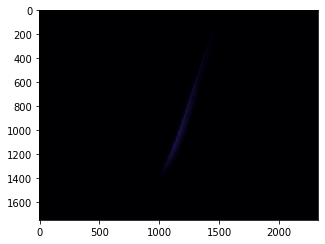

In [7]:
plt.figure(figsize=(5,5))
plt.imshow(clean.loc[-3.0,"tds_image"], cmap="magma", interpolation="None", vmin=0, vmax=4095)
plt.show()

In [2]:
# Convert TDS images to bunch profiles
    # Remove background from TDS images
    # Follow Sergey's TDS image processing

In [3]:
# Get CRISP formfactors

In [4]:
# Unite bunch profiles, CRISP high and CRISP low